In [1]:
# Run python sript if enter_parameters is needed.
# Run ipython or notebook with enter_parameters disabled if cell outputs need to be saved.
run_from_ipython = 'get_ipython' in globals()
# Use ipython display when running notebook. Print directly to console when running sript.
display = display if run_from_ipython else print

In [2]:
import os
import json
import numpy as np
import pandas as pd
import xarray as xr
import scipy.signal as ss
from scipy.interpolate  import interp1d
import matplotlib.pyplot as plt

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from allensdk.brain_observatory.ecephys.visualization import plot_spike_counts

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

from utils import *
from process import *
from analysis import *
from plots import *

if run_from_ipython:
    %matplotlib inline

with open('config.json') as f:
    config = json.load(f)

In [3]:
# Cache directory path, it determines where downloaded data will be stored
manifest_path = os.path.join(config['cache_dir'], "manifest.json")
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

# # Whether to manually enter parameters for analysis
# enter_parameters = config['enter_parameters']
# whether_redo = redo_condition(enter_parameters)

## Get session and probe

In [4]:
session_id = config['analysis_object']['session_id']
ecephys_structure_acronym = config['analysis_object']['ecephys_structure_acronym']

In [5]:
output_dir = config['output_dir']
session_dir = os.path.join(output_dir, f'session_{session_id:d}')
info_file = os.path.join(output_dir, f'session_{session_id:d}_{ecephys_structure_acronym:s}.json')
with open(info_file) as f:
    info = json.load(f)
print(json.dumps(info, indent=4))

probe_id = info['probe_id']
probe_dir = os.path.join(session_dir, f'probe_{probe_id:d}')
# parameters_dict = info['parameters']
# fig_disp = figure_display_function(config)

{
    "session_id": 721123822,
    "ecephys_structure_acronym": "VISp",
    "probe_id": 760213145,
    "center_channel_id": 850245983,
    "center_unit_channel_id": 850245985,
    "fs": 1249.99999145772,
    "parameters": {
        "spike_bin_width": 0.03,
        "fr_smooth_sigma": 0.02,
        "fr_normalize_quantile": 0.2,
        "fr_normalization_scale": "range",
        "soft_normalize_cut": 26.666666666666668,
        "stimulus_rise_duration": [
            -0.05,
            0.33
        ],
        "display_PCs": [
            1,
            2
        ],
        "number_top_PCs": 3,
        "select_temporal_frequency_index": [
            0,
            1,
            2,
            3
        ],
        "stimulus_stable_duration": [
            0.3,
            2.001770000000306
        ],
        "number_orientation_clusters": 3,
        "two_step_clustering": true,
        "filter_extend_time": 0.2,
        "filter_freq_band": [
            20.0,
            40.0
        ],
 

## Load selected units in area of interest

In [6]:
units_file = os.path.join(output_dir, f'session_{session_id:d}_{ecephys_structure_acronym:s}_units.csv')
sel_units = pd.read_csv(units_file, index_col='unit_id')
sel_units_id = sel_units.index
print(f'Number of units in {ecephys_structure_acronym:s}: {len(sel_units):d}')

Number of units in VISp: 41


## Load LFP channels

In [7]:
filepath = os.path.join(probe_dir, f'{ecephys_structure_acronym:s}_lfp_channel_groups.nc')
with xr.open_dataset(filepath) as f:
    lfp_array = f.load()
lfp_array = lfp_array.assign_attrs(fs=info['fs']).rename(group_id='channel')
lfp_array = lfp_array.transpose('channel', 'time')

In [8]:
channel_id = info['center_unit_channel_id']
channel_group_map = pd.read_csv(filepath.replace('.nc', '.csv'), index_col='id')

# group_id = channel_group_map.loc[channel_id, 'group_id']
group_id = 2
lfp_array = lfp_array.sel(channel=group_id)
display(lfp_array)

<xarray.Dataset>
Dimensions:  (time: 12263286)
Coordinates:
  * time     (time) float64 0.5328 0.5336 0.5344 ... 9.811e+03 9.811e+03
    channel  int32 2
Data variables:
    LFP      (time) float32 -3.725e-05 -4.966e-05 ... -7.169e-05 -5.609e-05
Attributes:
    fs:       1249.99999145772

## Analyze STP

In [9]:
# Processing parameters
fs = 50.  # Hz. firing rate sampling frequency
bin_width = 0.0025  # sec. spike count bin width
filt_sigma = 20.0  # ms. Gaussian filer sigma
extend_time = 0.5

# LFP parameters
normalize_wave = False
method = 'wavelet'  # method to obtain wave amplitude
wave_kwargs = {
    'filter': dict(
        waves = {'beta': (20., 40.), 'gamma': (40., 65.)},
        transform = wave_hilbert,
        filt_order = 4
    ),
    'wavelet': dict(
        waves = {'beta': 30., 'gamma': 53.},
        transform = wave_cwt,
        bandwidth = 1.33  # time band (inverse to frequency band), sigma of the gaussian envelope for frequency 1.0
    )
}
wave_kwargs = wave_kwargs[method]

# STP fitting parameters
separate_units = True  # whether fit individual weights for distinct units

tau = [200., 300., 450., 670, 1000., 1500.]  # ms
tau = np.asarray(tau).ravel() / 1000 # to sec
taui = tau * fs

lag_range = [-40, 60]  # ms. range time lags
lags = np.round(np.array(lag_range) / 1000 * fs).astype(int)
lags = np.arange(lags[0], lags[1] + 1)
t_lags = 1000 / fs * lags

# Select stimuli for analysis
# stimuli = None
# stimuli = ['drifting_gratings', 'natural_movie_three', 'natural_movie_one']
stimuli = ['drifting_gratings']
# stimuli = ['natural_movie_three', 'natural_movie_one']

In [10]:
overwrite = False  # whether overwrite data files

rspk_file = os.path.join(output_dir, f'session_{session_id:d}_{ecephys_structure_acronym:s}_unit_fr.npz')
suffix = method + ('_norm' if normalize_wave else '')
lfp_wave_file = os.path.join(probe_dir, f'{ecephys_structure_acronym:s}_lfp_group_{group_id:d}_{suffix:s}_waves.npz')
overwrite_rspk = overwrite or not os.path.isfile(rspk_file)
overwrite_lfp_wave = overwrite or not os.path.isfile(lfp_wave_file)

In [11]:
times = lfp_array.time.values[[0, -1]]
bin_edges = times[0] + bin_width * np.arange(np.ceil((times[1] - times[0]) / bin_width) + 1)
bin_times = bin_edges[:-1] + bin_width / 2
times = bin_times[0] + np.arange(np.ceil((bin_times[-1] - bin_times[0]) * fs)) / fs

In [12]:
# spike counts of selected units
if overwrite_rspk:
    # Check invalid time intervals for spike times
    session = cache.get_session_data(session_id)
    invalid_times = session.invalid_times
    invalid_id = [probe_id == int(tag[1]) for tag in invalid_times['tags']]
    if any(invalid_id):
        print("Invalid spike time data are included in time following time intervals.")
        display(invalid_times.loc[invalid_id, ['start_time', 'stop_time']])
    else:
        print("No invalid time intervals for spike time data encountered.")
    # Calculate spike rate
    tspk = session.spike_times
    rspk = np.array([spike_count(tspk[i], bin_edges) for i in sel_units_id])
    del tspk
    rspk = gauss_filt(rspk, filt_sigma / 1000 / bin_width)
    rspk = interp1d(bin_times, rspk, axis=-1, assume_sorted=True)(times)
    np.savez_compressed(rspk_file, unit_fr=rspk)
else:
    with np.load(rspk_file) as f:
        rspk = f['unit_fr']

In [13]:
if overwrite_lfp_wave:
    # Get LFP wave amplitude
    lfp_wave = get_waves(lfp_array.LFP, lfp_array.fs, axis=-1, component='amp', **wave_kwargs)
    # Get LFP power
    if normalize_wave:
        lfp_power = gauss_filt(lfp_array.LFP ** 2, filt_sigma / 1000 * lfp_array.fs)
    # downsample
    lfp_wave = interp1d(lfp_array.time, lfp_wave, axis=-1, assume_sorted=True)(times)
    # normalize by sqrt power
    if normalize_wave:
        lfp_power = interp1d(lfp_array.time, lfp_power, axis=-1, assume_sorted=True)(times)
        lfp_wave /= lfp_power ** 0.5
        del lfp_power
    waves = np.array(list(wave_kwargs['waves']))
    np.savez_compressed(lfp_wave_file, lfp_wave=lfp_wave, waves=waves, **wave_kwargs['waves'], normalize_wave=int(normalize_wave))
else:
    with np.load(lfp_wave_file) as f:
        lfp_wave = f['lfp_wave']
        waves = f['waves']

In [14]:
i_start = pd.Index(times).get_indexer([times[0] + extend_time], method='bfill')[0]
i_start = max(i_start, - lags[0])
T = times.size - lags[-1]
time = times[i_start:T]

In [15]:
wave_lag = np.stack([lfp_wave[:, i_start + i:T + i] for i in lags], axis=-1)
wave_lag = np.moveaxis(wave_lag, 0, -2)
wave_lag = wave_lag.reshape(-1, np.prod(wave_lag.shape[-2:]))
targets = pd.MultiIndex.from_product([waves, t_lags], names=['waves', 'lags'])

if 'w_stps' not in globals() or 'fr_tots' not in globals():
    w_stps, fr_tots = stp_weights(rspk, taui, i_start=i_start, i_stop=T, unit_axis=None if separate_units else -2)

w_stp, fr_tot = w_stps.copy(), fr_tots.copy()

In [16]:
if stimuli:
    if 'stimulus_epochs' not in globals():
        session = cache.get_session_data(session_id)
        stimulus_epochs = session.get_stimulus_epochs()
        stimulus_epochs = stimulus_epochs[stimulus_epochs['stimulus_block'] != 'null']
        stimulus_epochs['stimulus_block'] = stimulus_epochs['stimulus_block'].astype(int)
        stimulus_epochs = stimulus_epochs.set_index('stimulus_block')

    stimuli_blocks = {s: stimulus_epochs.loc[stimulus_epochs['stimulus_name'] == s].index.tolist() for s in stimuli}
    blocks = sum(stimuli_blocks.values(), [])
    blocks = dict((zip(blocks, range(len(blocks)))))
    block_windows = stimulus_epochs.loc[list(blocks), ['start_time', 'stop_time']].values

    t_idx = np.zeros_like(time, dtype=bool)
    for t1, t2 in block_windows:
        t_idx |= (time >= t1) & (time <= t2)
    t_idx = np.nonzero(t_idx)[0]

    time = time[t_idx]
    w_stp = np.take(w_stp, t_idx, axis=-1)
    fr_tot = np.take(fr_tot, t_idx, axis=-1)
    wave_lag = np.take(wave_lag, t_idx, axis=0)

In [17]:
# separate_units = False
# w_stp = np.mean(w_stp, axis=-2)
# fr_tot = np.mean(fr_tot, axis=-2)

### Predict wave amplitude with spike data

In [18]:
color = {'beta': 'tab:purple', 'gamma': 'tab:red'}

root_mean_squared_error = lambda *arg, **kwargs: mean_squared_error(*arg, **kwargs) ** 0.5
error_metrics = {'R2 score': r2_score, 'RMSE': root_mean_squared_error}

def optimal_error(err_da, opt_idx):
    dim_opt = {dim: xr.DataArray(idx.values, dims='optimal') for dim, idx in opt_idx.items()}
    opt_err = err_da.isel(waves=xr.DataArray(range(waves.size),
        coords={'optimal': waves}), **dim_opt).transpose('optimal', 'metric')
    return opt_err

Regression using only total firing rate input

In [19]:
X = fr_tot.T if separate_units else fr_tot[:, None]

fr_reg = LinearRegression()
fr_reg.fit(X, wave_lag)
fr_pred = fr_reg.predict(X)

fr_pred_error = xr.DataArray([m(wave_lag, fr_pred, multioutput='raw_values') \
    for m in error_metrics.values()], name='prediction error',
    coords=dict(metric=list(error_metrics), target=targets)).unstack('target')

fr_optimal_idx = fr_pred_error.sel(metric='RMSE').argmin(dim=['lags'])
fr_optimal_param = xr.Dataset({d: fr_pred_error.coords[d][fr_optimal_idx[d]] for d in ['lags']})
print("Optimal parameters:")
display(fr_optimal_param.to_pandas())
print("Minimum error:")
fr_opt_error = optimal_error(fr_pred_error, fr_optimal_idx)
display(fr_opt_error.to_pandas())

Optimal parameters:


,metric,lags
waves,,
beta,RMSE,0.0
gamma,RMSE,0.0


Minimum error:


metric,R2 score,RMSE
optimal,,
beta,0.235382,0.000037
gamma,0.122082,0.000018


Regression using STP weights

In [20]:
stp_fr_reg = [LinearRegression() for _ in range(tau.size)]
pred = []
for i, reg in enumerate(stp_fr_reg):
    X = np.stack((w_stp[i], fr_tot), axis=1).reshape(-1, w_stp.shape[-1]).T if separate_units \
        else np.column_stack((w_stp[i], fr_tot))
    reg.fit(X, wave_lag)
    pred.append(reg.predict(X))

pred_error = xr.DataArray([[m(wave_lag, y, multioutput='raw_values') \
    for m in error_metrics.values()] for y in pred], name='prediction error',
    coords=dict(tau=tau, metric=list(error_metrics), target=targets)).unstack('target')

In [21]:
param_dims = {'tau': 'Time constant (sec)', 'lags': 'Time lags (ms)'}
optimal_idx = pred_error.sel(metric='RMSE').argmin(dim=list(param_dims))
optimal_param = xr.Dataset({d: pred_error.coords[d][optimal_idx[d]] for d in param_dims})

print("Optimal parameters:")
display(optimal_param.to_pandas())
print("Minimum error:")
opt_error = optimal_error(pred_error, optimal_idx)
display(opt_error.to_pandas())

Optimal parameters:


,metric,tau,lags
waves,,,
beta,RMSE,0.30,0.0
gamma,RMSE,0.45,0.0


Minimum error:


metric,R2 score,RMSE
optimal,,
beta,0.267777,0.000037
gamma,0.141686,0.000018


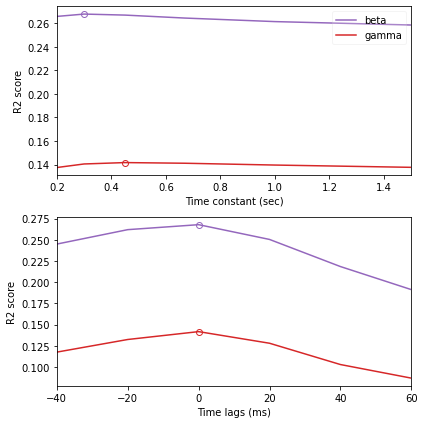

In [28]:
error = pred_error.sel(metric='R2 score')

axs = plt.subplots(len(param_dims), 1, figsize=(6, 3 * len(param_dims)), squeeze=False)[1].ravel()
for ax, (pdm, label) in zip(axs, param_dims.items()):
    for w in waves:
        opt_p = optimal_param.sel(waves=w)
        err = error.sel(waves=w, **{d: opt_p[d] for d in param_dims if d != pdm})
        ax.plot(error[pdm], err, color=color[w], label=w)
        ax.plot(opt_p[pdm], err.sel(**{pdm: opt_p[pdm]}),
                color=color[w], marker='o', markerfacecolor='none')
    ax.set_xlim(error[pdm][[0, -1]])
    ax.set_xlabel(label)
    ax.set_ylabel(error.metric.item())
axs[0].legend(loc='upper right', framealpha=0.2)
plt.tight_layout()
plt.show()

In [23]:
linestyle = {'actual': '-', 'predict': '--'}
opt_pred = []
opt_coef = []
for w in waves:
    opt_p = optimal_param.sel(waves=w)
    trg = (w, opt_p.lags.item())
    trg_idx = targets.get_loc(trg)
    opt_lag_fr = wave_lag[:, trg_idx]
    tau_idx = pred_error.tau.to_index().get_loc(opt_p.tau.item())
    opt_fr_pred = pred[tau_idx][:, trg_idx]
    opt_pred.append([opt_lag_fr, opt_fr_pred])
    opt_reg = stp_fr_reg[tau_idx]
    opt_coef.append(opt_reg.coef_[trg_idx].tolist() + [opt_reg.intercept_[trg_idx]])

opt_pred = xr.DataArray(opt_pred, name='optimal prediction', coords=dict(
    waves=waves, output=list(linestyle), time=time))

if separate_units:
    n = fr_tot.shape[0]
    coef_names = np.append(np.array([['a' + str(i), 'b' + str(i)] for i in range(n)]).ravel(), 'c')
else:
    coef_names = ['a', 'b', 'c']
opt_coef = xr.DataArray(opt_coef, name='optimal coefficient', coords=dict(
    waves=waves, coef=coef_names))

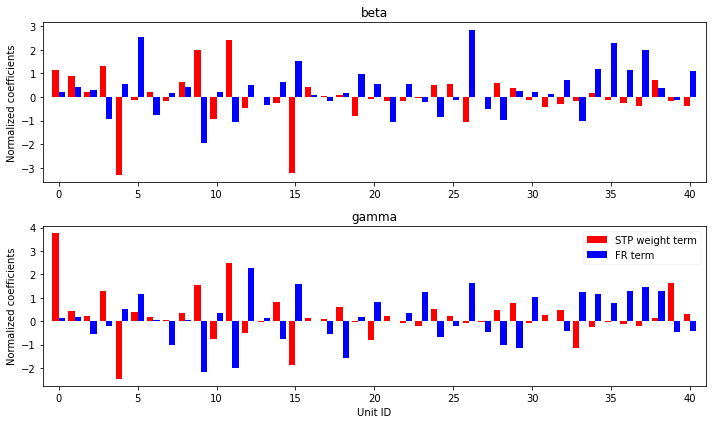

In [24]:
if separate_units:
    figsize = (10, 3)
    bargap = 0.2
    bw = (1 - bargap) / 2
    norm = lambda x: x / x.std()

    axs = plt.subplots(waves.size, 1, figsize=(figsize[0], figsize[1] * waves.size), squeeze=False)[1].ravel()
    for ax, w in zip(axs, waves):
        ax.bar(np.arange(n) - bw / 2, norm(opt_coef.sel(waves=w)[:-1:2]), width=bw, color='r', label='STP weight term')
        ax.bar(np.arange(n) + bw / 2, norm(opt_coef.sel(waves=w)[1:-1:2]), width=bw, color='b', label='FR term')
        ax.set_ylabel('Normalized coefficients')
        ax.set_title(w)
        ax.set_xlim(-1, n)
    ax.set_xlabel('Unit ID')
    ax.legend(loc='upper right', framealpha=0.2)
    plt.tight_layout()
    plt.show()
else:
    display(opt_coef)

Stimuli blocks:
{'drifting_gratings': [2, 5, 7]}


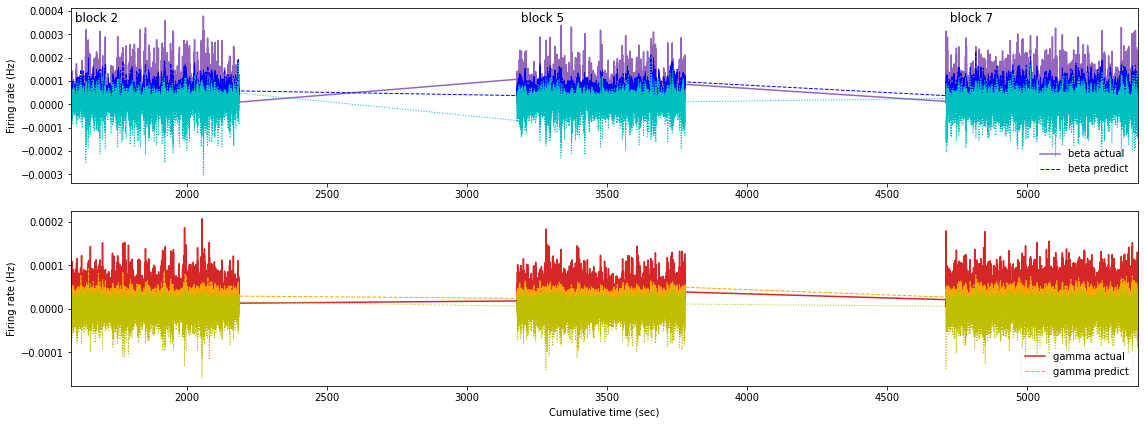

In [25]:
pred_clr = {'gamma': 'orange', 'beta': 'blue'}
err_clr = {'gamma': 'y', 'beta': 'c'}

figsize = (16, 3)
axs = plt.subplots(waves.size, 1, figsize=(figsize[0], figsize[1] * waves.size), squeeze=False)[1].ravel()
t = opt_pred.time
for w, ax in zip(waves, axs):
    Ys = opt_pred.sel(waves=w)
    for y in opt_pred.output.values:
        clr = pred_clr[w] if y == 'predict' else color[w]
        linewidth = 1 if y == 'predict' else 1.5
        label = f'{w} {y}'
        ax.plot(t, Ys.sel(output=y), color=clr, linewidth=linewidth,
                linestyle=linestyle[y], label=label)
    ax.plot(t, Ys.sel(output='predict') - Ys.sel(output='actual'), color=err_clr[w],
            linewidth=linewidth, linestyle=':', label=None if i else 'error')
for ax in axs:
    ax.set_xlim(t[[0, -1]])
    ax.set_ylabel('Firing rate (Hz)')
    ax.legend(loc='lower right', framealpha=0.2)
axs[-1].set_xlabel('Cumulative time (sec)')
if stimuli:
    from matplotlib.transforms import blended_transform_factory
    print("Stimuli blocks:")
    print(stimuli_blocks)
    ax = axs[0]
    trans = blended_transform_factory(ax.transData, ax.transAxes)
    for b, bw in zip(blocks, block_windows):
        ax.text(bw[0], 0.98, ' block ' + str(b), transform=trans, fontsize='large',
                horizontalalignment='left', verticalalignment='top')
plt.tight_layout()
plt.show()

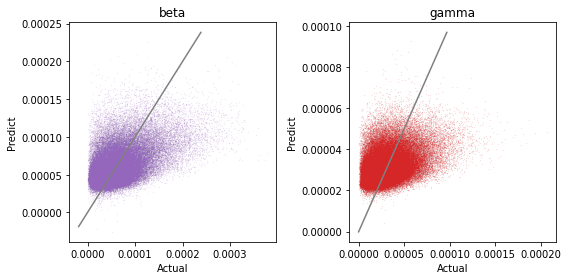

In [26]:
figsize = (4, 4)
axs = plt.subplots(1, waves.size, figsize=(figsize[0] * waves.size, figsize[1]), squeeze=False)[1].ravel()
for w, ax in zip(waves, axs):
    Ys = opt_pred.sel(waves=w)
    ax.plot(Ys.sel(output='actual'), Ys.sel(output='predict'), '.',
            color=color[w], markersize=0.1)
    xl, yl = ax.get_xlim(), ax.get_ylim()
    xl = [max(xl[0], yl[0]), min(xl[1], yl[1])]
    ax.plot(xl, xl, 'gray')
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predict')
    ax.set_title(w)
plt.tight_layout()
plt.show()

### Target specific stimulus

In [27]:
# present_time = 'time_from_presentation_onset'
# # Get stimulus trials
# drifting_gratings_presentations, grating_ids, grating_times, grating_duration = align_gratings(
#     session.stimulus_presentations, stimulus_name='drifting_gratings')
# aligned_lfp = align_trials(lfp_array, grating_ids, grating_times, window=(0. - extend_time, grating_duration + extend_time))
# aligned_lfp = aligned_lfp.assign_attrs(extend_time=extend_time)
# # LFP power
# aligned_lfp = aligned_lfp.assign(LFP_power=gauss_filt_da(aligned_lfp.LFP ** 2, filt_sigma / 1000 * aligned_lfp.fs, dim=present_time))

# # display(aligned_lfp)


# time = getattr(aligned_lfp, present_time)[[0, -1]] * fs
# time = np.arange(np.ceil(time[0]), np.floor(time[1]) + 1) / fs
# bin_edges = time[[0, -1]] / bin_width
# bin_edges = np.arange(np.ceil(bin_edges[0]) - 0.5, np.floor(bin_edges[1]) + 1.5) * bin_width


# # Get filtered LFP
# lfp_wave = xr.concat([bandpass_lfp(aligned_lfp, f, output='sos').amplitude for f in freq_band.values()],
#                      dim=pd.Index(list(freq_band), name='wave'))
# lfp_wave = lfp_wave.interp(**{present_time=time}, method='linear', assume_sorted=True).assign_attrs(fs=fs)
# # normalize by sqrt power
# lfp_wave = lfp_wave / aligned_lfp.LFP_power.interp(**{present_time=time}, method='linear', assume_sorted=True) ** 0.5
# lfp_wave = lfp_wave.transpose('wave', 'presentation_id', present_time)

# # display(lfp_wave)


# # Get firing rates
# time_dim = 'time_relative_to_stimulus_onset'
# unit_dim = 'unit_id'

# rspk = session.presentationwise_spike_counts(stimulus_presentation_ids=grating_ids, unit_ids=sel_units_id, bin_edges=bin_edges)
# dims = list(rspk.dims)
# dims.append(dims.pop(dims.index(time_dim)))
# unit_axis = dims.index(unit_dim) - len(dims)

# # Gaussian filt
# rspk_filt = gauss_filt_da(rspk.astype(float), filt_sigma / 1000 / bin_width, dim=time_dim)
# rspk_filt = rspk_filt.interp(**{time_dim: time}, method='linear', assume_sorted=True)
# rspk_filt = rspk_filt.transpose(*dims)
# i_start = pd.Index(time).get_indexer([0.], method='bfill')[0]
# T = time.size - lags[-1]


# # Calculate STP
# w_stp, fr_tot = stp_weights(rspk_filt, taui, unit_axis=unit_axis, i_start=i_start, i_stop=T)
# w_stp = w_stp.reshape(w_stp.shape[0], -1)
# fr_tot = fr_tot.ravel()

# wave_lag = lfp_wave.values
# wave_lag = wave_lag.reshape(wave_lag.shape[0], -1, wave_lag.shape[-1])
# wave_lag = np.stack([wave_lag[:, :, i_start + i:T + i] for i in lags], axis=-1)
# wave_lag = np.moveaxis(wave_lag, 0, -2)
# wave_lag = wave_lag.reshape(-1, np.prod(wave_lag.shape[-2:]))